# Multiwavelength astronomy: GALAH/Gaia meets Radio Stars

A hands-on tutorial on matching optical and radio observations for the [2025 Australia/eROSITA-DE multi-wavelength school](https://astronomyaustralia.org.au/event/2025-australia-erosita-de-multi-wavelength-school/).

This notebook shows you how to crossmatch GALAH DR4 (Buder et al. 2025) with the Sydney Radio Star Catalogue by Driessen et al. (2024) and create some first plots with the overlap.

Author: Sven Buder (ANU, sven.buder@anu.edu.au)

In [1]:
# Read in python packages etc. including required packages: numpy, matplotlib, astropy, astroquery

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import os

# Basic packages
import numpy as np

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter

# astropy
from astropy.table import Table, join

# astroquery
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1 # Make sure we download all rows, not just the default first 50


panels = ['a)','b)','c)','d)','e)','f)','g)','i)','j)','k)','l)','m)','n)','o)','p)','q)','s)','t)','u)','v)','w)','x)','y)','z)']

def rv_shift(rv_value, wavelength):
    return(wavelength / (1.+rv_value/299792.458))

## 1 Data

### 1.1 GALAH DR4

Paper: https://ui.adsabs.harvard.edu/abs/2024arXiv240919858B  
Table: https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_allstar_240705.fits

In [2]:
# Read in GALAH DR4 as *galah_allstar* 
try:
    galah_allstar = Table.read('data/galah_dr4_allstar_240705.fits')
    galah_allstar_finite_cmd = np.isfinite(galah_allstar['r_med']) & np.isfinite(galah_allstar['bp_rp'])
except:
    # Fall-back option for the multi wavelength school
    galah_allstar = Table.read('data/galah_dr4_allstar_240705_ids_only.fits')

### 1.2 Sydney Radio Star Catalogue (Driessen+, 2024)

Paper: https://ui.adsabs.harvard.edu/abs/2025PASP..137a4201R  
Table: J/PASP/137/A4201/cv_1000 @ VizieR

In [3]:
# Download the catalogue from VizieR
radio_stars = Vizier.get_catalogs('J/other/PASA/41.84/stars')[0]

# We can only crossmatch sources that have a match in Gaia DR3.
radio_stars = radio_stars[radio_stars['Gaia'] != '']

# We need to transform the Gaia DR3 *** string to an integer with only the integers ***
radio_stars['gaiadr3_source_id'] = np.array([source_id[9:] for source_id in radio_stars['Gaia']], dtype=np.int64)

## 1.3 Crossmatch for extra Gaia DR3 measurements

The VizieR version does not provide additional Gaia columns. No problem! Let's use astroquery to get them!

In [8]:
# Let's login to the Gaia archive. Note: You need an account at https://gea.esac.esa.int/archive/
from astroquery.gaia import Gaia
user = 'sbuder'
Gaia.login(user = user)

INFO: Login to gaia TAP server [astroquery.gaia.core]
Password: ········
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]


In [5]:
# Upload the table to the Gaia TAP+ service
try:
    Gaia.upload_table(upload_resource=radio_stars[['gaiadr3_source_id']], table_name='radio_stars')
except:
    print('Already uploaded radio_stars?')

INFO: Sending pytable. [astroquery.utils.tap.core]
500 Error 500:
java.lang.IllegalStateException: Can't overwrite cause with uk.ac.starlink.table.TableFormatException: Can not execute the following SQL: 
CREATE TABLE user_sbuder.radio_stars ( "gaiadr3_source_id" bigint,  radio_stars_oid SERIAL ) TABLESPACE gacs_netapp
Because: ERROR: relation "radio_stars" already exists
Already uploaded radio_stars?


In [9]:
# Write your ADQL query using the uploaded table to get
# a) Gaia magnitudes/colors and 
# b) Bailer-Jones Bayesian distances (much better for distance uncertainties > 20%)
query = f"""
SELECT 
    radio_stars.gaiadr3_source_id,
    g.phot_g_mean_mag,
    g.bp_rp,
    b.r_med_photogeo,
    b.r_lo_photogeo,
    b.r_hi_photogeo
FROM 
    user_"""+user+""".radio_stars AS radio_stars
JOIN 
    gaiadr3.gaia_source AS g
    ON g.source_id = radio_stars.gaiadr3_source_id
JOIN 
    external.gaiaedr3_distance AS b
    ON g.source_id = b.source_id
"""

# Run the query
job = Gaia.launch_job(query)
radio_gaia_extra = job.get_results()

radio_gaia = join(radio_stars, radio_gaia_extra, keys = 'gaiadr3_source_id')

In [11]:
len(radio_gaia)

820

### 1.3 Joined Catalogue

In [12]:
radio_ga_ga = join(radio_gaia, galah_allstar, keys = 'gaiadr3_source_id')
len(radio_ga_ga)

42

## 2 First plots

### 2.1 Radial velocity variations (signs of binarity)?

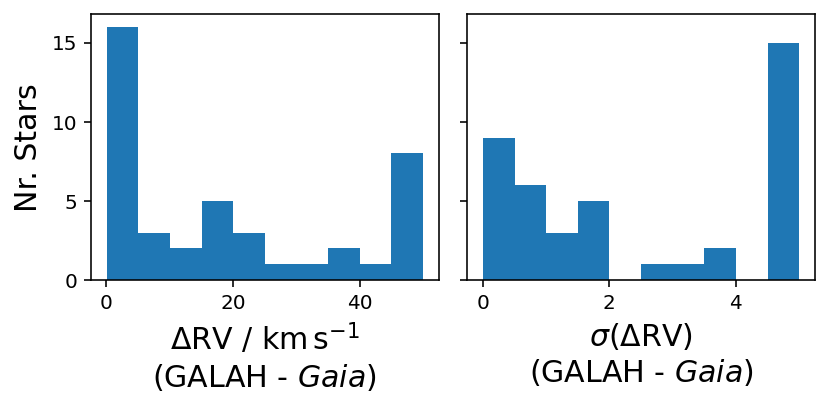

In [13]:
def plot_rv_difference_and_uncertainty():
    f, gs = plt.subplots(1,2,sharey=True,figsize=(6,3))
    ax = gs[0]
    ax.set_xlabel(r'$\Delta\mathrm{RV}~/~\mathrm{km\,s^{-1}}$'+'\n(GALAH - '+'$Gaia$)',fontsize=15)
    ax.set_ylabel(r'Nr. Stars',fontsize=15)
    ax.hist(
        abs(radio_ga_ga['rv_comp_1'] - radio_ga_ga['rv_gaia_dr3']).clip(max=50)
    );

    ax = gs[1]
    ax.hist(
        (
            abs(radio_ga_ga['rv_comp_1'] - radio_ga_ga['rv_gaia_dr3']) / 
            np.sqrt(radio_ga_ga['e_rv_comp_1']**2 + radio_ga_ga['e_rv_gaia_dr3']**2)
        ).clip(max = 5)
    )
    ax.set_xlabel(r'$\sigma(\Delta\mathrm{RV})$'+'\n(GALAH - '+'$Gaia$)',fontsize=15)
    plt.tight_layout()
    plt.show()
    plt.close()
plot_rv_difference_and_uncertainty()
# We see that the typical RV uncertainty is < 5 km/s.
# Yet, two radial velocity measurements differ significantly beyond this uncertainty! Binaries?

In [14]:
# Let's check for stars with significant RV differences and emission in Halpha

radio_ga_ga['binary_flag'] = np.zeros(len(radio_ga_ga['teff']),dtype=int)

# binary_flag 1: sigma(rv) > 3 between GALAH and Gaia
significant_rv_difference = (
        abs(radio_ga_ga['rv_comp_1'] - radio_ga_ga['rv_gaia_dr3']) / 
        np.sqrt(radio_ga_ga['e_rv_comp_1']**2 + radio_ga_ga['e_rv_gaia_dr3']**2)
    ) > 3
radio_ga_ga['binary_flag'][significant_rv_difference] += 1

# binary_flag 2: Halpha in emission
halpha_in_emission = (radio_ga_ga['ew_h_alpha'] < 0)
radio_ga_ga['binary_flag'][halpha_in_emission] += 2

def is_flag_raised(binary_flag):
    return (radio_ga_ga['binary_flag'] & binary_flag) != 0

is_binary = radio_ga_ga['binary_flag'] > 0
is_rv_binary = is_flag_raised(binary_flag=1)
is_emission_binary = is_flag_raised(binary_flag=2)

### 2.2 Color-Magnitude Diagrams?

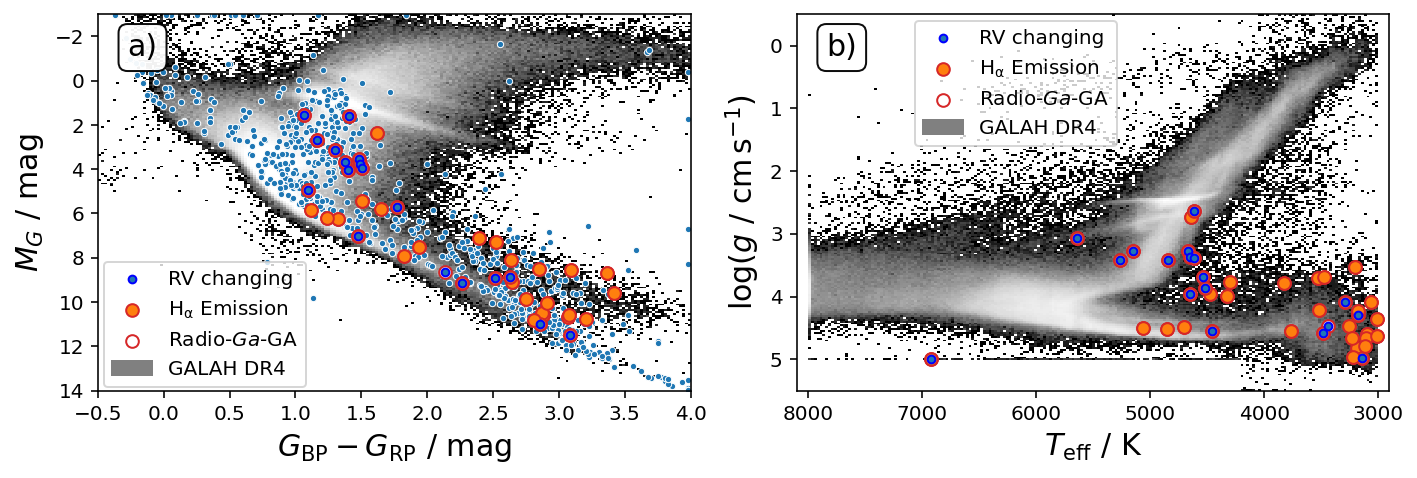

In [20]:
def plot_radio_star_cmd_and_kiel():
    f, gs = plt.subplots(1,2,figsize=(10,3.5))

    ########################################################################
    ax = gs[0]
    ax.text(0.05,0.95,panels[0],transform=ax.transAxes,fontsize=15,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$G_\mathrm{BP} - G_\mathrm{RP}~/~\mathrm{mag}$',fontsize=15)
    ax.set_ylabel(r'$M_G~/~\mathrm{mag}$',fontsize=15)

    xlim = (-0.5,4)
    ylim = (-3,14)

    hist_bins = (np.linspace(xlim[0],xlim[1],200),np.linspace(ylim[0],ylim[1],200))

    h = ax.hist2d(
        galah_allstar['bp_rp'][galah_allstar_finite_cmd],
        galah_allstar['phot_g_mean_mag'][galah_allstar_finite_cmd] - 5*np.log10(galah_allstar['r_med'][galah_allstar_finite_cmd]/10),
        bins = hist_bins,
        cmin = 1, cmap = 'Greys_r', norm=LogNorm(vmax = 500),
        label = 'GALAH DR4'
    )
    hist2d_patch = mpatches.Patch(color='grey', label='GALAH DR4')

    s = ax.scatter(
        np.array(radio_gaia['bp_rp']).clip(min=xlim[0]+0.02,max=xlim[1]-0.02),
        np.array(radio_gaia['phot_g_mean_mag']-5*np.log10(radio_gaia['r_med_photogeo']/10)).clip(min=ylim[0]+0.02,max=ylim[1]-0.02),
        label = 'Radio Stars', lw=0.5, edgecolor='w', c='C0', s=10
    )

    s3 = ax.scatter(
        radio_ga_ga['bp_rp_1'],
        radio_ga_ga['phot_g_mean_mag_1'] - 5*np.log10(radio_ga_ga['r_med']/10),
        label = 'Radio-$Ga$-GA', lw=1, edgecolor='C3', c='w', s=40
    )
    s2 = ax.scatter(
        radio_ga_ga['bp_rp_1'][is_emission_binary],
        radio_ga_ga['phot_g_mean_mag_1'][is_emission_binary] - 5*np.log10(radio_ga_ga['r_med'][is_emission_binary]/10),
        label = r'$\mathrm{H_\alpha}$ Emission', lw=1, edgecolor='C3', c='C1', s=40
    )
    s1 = ax.scatter(
        radio_ga_ga['bp_rp_1'][is_rv_binary],
        radio_ga_ga['phot_g_mean_mag_1'][is_rv_binary] - 5*np.log10(radio_ga_ga['r_med'][is_rv_binary]/10),
        label = 'RV changing', lw=1, edgecolor='b', c='C0', s=15
    )

    legend = ax.legend(handles=[s1, s2, s3, hist2d_patch],loc = (0.01,0.01))

    ax.set_xlim(xlim)
    ax.set_ylim(ylim[1],ylim[0])

    ########################################################################
    ax = gs[1]
    ax.text(0.05,0.95,panels[1],transform=ax.transAxes,fontsize=15,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

    hist_bins = (np.linspace(3000,8000,200),np.linspace(-0.5,5.5,200))

    h = ax.hist2d(
        galah_allstar['teff'][galah_allstar_finite_cmd],
        galah_allstar['logg'][galah_allstar_finite_cmd],
        bins = hist_bins,
        cmin = 1, cmap = 'Greys_r', norm=LogNorm(),
        label = 'GALAH DR4'
    )
    hist2d_patch = mpatches.Patch(color='grey', label='GALAH DR4')

    s3 = ax.scatter(
        radio_ga_ga['teff'],
        radio_ga_ga['logg'],
        label = 'Radio-$Ga$-GA', lw=1, edgecolor='C3', c='w', s=40
    )
    s2 = ax.scatter(
        radio_ga_ga['teff'][is_emission_binary],
        radio_ga_ga['logg'][is_emission_binary],
        label = r'$\mathrm{H_\alpha}$ Emission', lw=1, edgecolor='C3', c='C1', s=40
    )
    s1 = ax.scatter(
        radio_ga_ga['teff'][is_rv_binary],
        radio_ga_ga['logg'][is_rv_binary],
        label = 'RV changing', lw=1, edgecolor='b', c='C0', s=15
    )

    legend = ax.legend(handles=[s1, s2, s3, hist2d_patch],loc = (0.2,0.65))

    ax.set_ylim(5.5,-0.5)
    ax.set_xlim(8100,2900)
    ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
    ax.set_ylabel(r'$\log (g~/~\mathrm{cm\,s^{-1}})$',fontsize=15)

    plt.tight_layout()
    plt.savefig('figures/radio_ga_ga_hrd_kiel.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()
plot_radio_star_cmd_and_kiel()

In [ ]:
# Let's try to download the GALAH data products (some may not exist if the pipeline was not run successfully.)
def download_galah_data_products(sobject_id):
    os.makedirs('galah_data/'+str(sobject_id),exist_ok=True)
    
    # Try to download the radial velocity comparison of repeat observations and Gaia
    os.system('wget --no-clobber -P galah_data/'+str(sobject_id)+' https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_allstar_rv_comparison.png')
    
    # Try to download the radial velocity fit
    os.system('wget --no-clobber -P galah_data/'+str(sobject_id)+' https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_allstar_fit_rv.png')

    # Try to download the spectrum
    os.system('wget --no-clobber -P galah_data/'+str(sobject_id)+' https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_allstar_fit_spectrum.fits')
    
    # Try to download the quick-view comparison
    os.system('wget --no-clobber -P galah_data/'+str(sobject_id)+' https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_allstar_fit_comparison.pdf')

for sobject_id in radio_ga_ga['sobject_id'][:2]:
    download_galah_data_products(sobject_id)

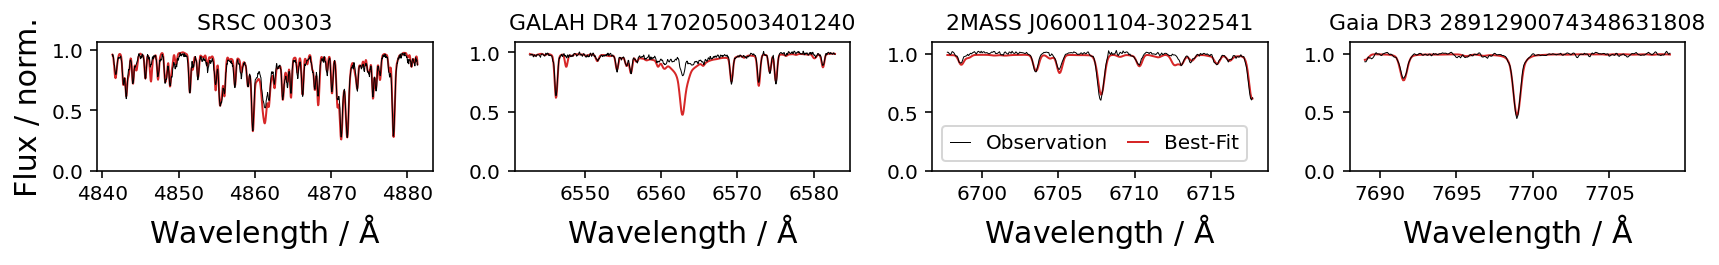

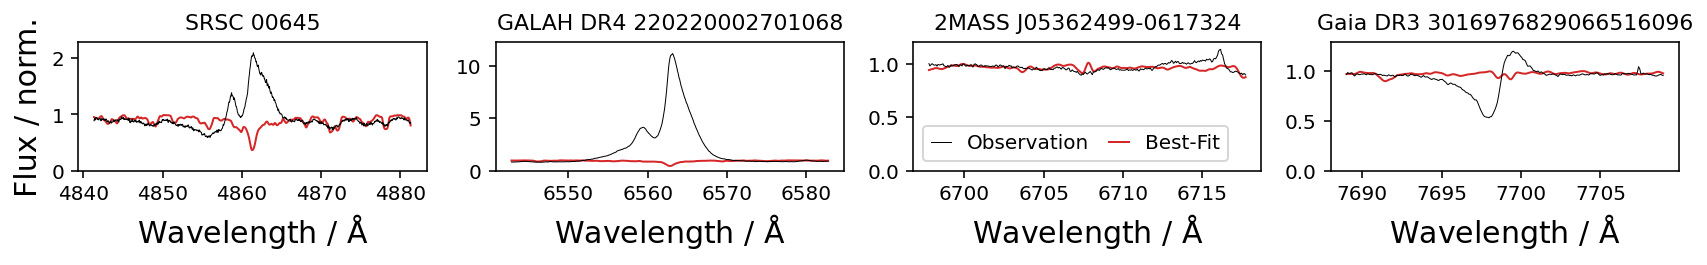

In [21]:
def plot_spectral_regions(data_row):
    
    sobject_id = str(data_row['sobject_id'])
    
    spectrum = Table.read('galah_data/'+str(sobject_id)+'/'+str(sobject_id)+'_allstar_fit_spectrum.fits')

    ranges = dict()
    ranges['Hbeta'] = [4861.3230-20,4861.3230+20]
    ranges['Halpha'] = [6562.7970-20,6562.7970+20]
    ranges['Li'] = [6707.7635-10,6707.7635+10]
    ranges['K'] = [7698.9643-10,7698.9643+10]
    nr_subplots = len(list(ranges.keys()))

    f, gs = plt.subplots(1,nr_subplots,figsize=(3*nr_subplots,2))

    for index, line in enumerate(ranges.keys()):

        ax = gs[index]
        in_region = (spectrum['wave'] > ranges[line][0]) & (spectrum['wave'] < ranges[line][1])

        ax.plot(
            spectrum['wave'][in_region],
            spectrum['sob'][in_region],
            c = 'k', lw=0.5, label = 'Observation',
            zorder = 2
        )
        ax.plot(
            spectrum['wave'][in_region],
            spectrum['smod'][in_region],
            c = 'C3', lw=1, label = 'Best-Fit',
            zorder  = 1
        )

        if index == 0:
            ax.set_ylabel('Flux / norm.', fontsize=15)
            ax.set_title(str(data_row['Ident']),fontsize=11)
        if index == 1:
            ax.set_title('GALAH DR4 '+str(data_row['sobject_id']),fontsize=11)
        if index == 2:
            ax.set_title('2MASS J'+str(data_row['tmass_id']),fontsize=11)
            ax.legend(ncol=2,fontsize=10,handlelength=1,columnspacing=1)
        if index == 3:
            ax.set_title('Gaia DR3 '+str(data_row['gaiadr3_source_id']),fontsize=11)
        ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$',fontsize=15)

        ylim = ax.get_ylim()
        ax.set_ylim(0.0,1.05*ylim[1])

    plt.tight_layout(w_pad=0)
    plt.savefig('figures/spectral_zoom_'+sobject_id+'.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()

for data_row in radio_ga_ga[:2]:
    plot_spectral_regions(data_row)

# Anything interesting?

# Pre-main-sequence stars / Young Stellar objects:
# - no strong Halpha absorption yet or even strong Halpha emission
# - strong Li-absorption at 6708 Å

In [18]:
# Note also:
# SRSC 00303 is also known as Washington Double Star  	WDS J03257+0551C
# SRSC 00645 is also known as Rosat X-ray Source RX J0331.1+0713